<a href="https://colab.research.google.com/github/oraziotorre/MomentumShiftAI/blob/main/TennisDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
! gdown --id 1IQsrji18SquiotFXbO5MlAucnOf54LNK

#15lhAvqBFpQeVMbqYgjQU4HUTx-QPam2R

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1IQsrji18SquiotFXbO5MlAucnOf54LNK
From (redirected): https://drive.google.com/uc?id=1IQsrji18SquiotFXbO5MlAucnOf54LNK&confirm=t&uuid=5c429f60-a01f-4996-bccb-fa54796e55e7
To: /content/tennis.csv
100% 236M/236M [00:03<00:00, 63.3MB/s]


In [22]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import brier_score_loss, log_loss

In [23]:
# Importiamo il dataset ottenuto tramite le operazioni di Data Preprocessing
dataset = pd.read_csv("tennis.csv")

In [29]:
# Generazione delle partite inverse per aumentare la dimensione del dataset

def augment_with_symmetric(df: pd.DataFrame) -> pd.DataFrame:
    df_swapped = df.copy()

    # Colonne da swappare a coppie
    swap_pairs = [
        ('Set1', 'Set2'),
        ('Gm1', 'Gm2'),
        ('Pt1', 'Pt2'),
        ('Player1', 'Player2'),
        ('Ranking1', 'Ranking2'),
        ('p1_win_nobreak_point', 'p2_win_nobreak_point'),
        ('p1_win_break_point', 'p2_win_break_point'),
        ('p1_lost_nobreak_point', 'p2_lost_nobreak_point'),
        ('p1_lost_break_point', 'p2_lost_break_point'),
        ('serve_ace_1', 'serve_ace_2'),
        ('serve_miss2_1', 'serve_miss1_2'),
        ('rally_winner_1', 'rally_winner_2'),
        ('rally_forced2_1', 'rally_forced1_2'),
        ('rally_unforced1_2', 'rally_unforced2_1')
    ]
    for col1, col2 in swap_pairs:
        df_swapped[[col1, col2]] = df[[col2, col1]].values

    # Colonne dove 1 <-> 2
    invert_1_2_cols = ['Svr', 'PtWinner', 'GameWinner']
    for col in invert_1_2_cols:
        df_swapped[col] = df[col].replace({1: 2, 2: 1})


    # Aggiunta del suffisso 'simm' a match_id e set_id, se presenti
    for col in ['MatchID', 'GameID']:
        if col in df_swapped.columns:
            df_swapped[col] = df_swapped[col].astype(str) + '_simm'

    return pd.concat([df, df_swapped], ignore_index=True)


dataset = augment_with_symmetric(dataset)

In [27]:
def game_win_prob(p, x=0, y=0):
    """Probabilità di vincere un game partendo dal punteggio x-y"""

    x = int(x)
    y = int(y)

    if x >= 4 and x - y >= 2:
        return 1.0
    elif y >= 4 and y - x >= 2:
        return 0.0

    if x == 4 and y == 3:
        return (p) + (1 - p) * (p**2) / (1 - 2 * p * (1 - p))
    elif y == 4 and x == 3:
        return (p**3) / (1 - 2 * p * (1 - p))

    # Parte pre-deuce
    sum_part1 = 0
    for i in range(0, 3 - y):
        sum_part1 += p**(4 - x) * math.comb(3 + i - x, i) * (1 - p)**i

    # Parte deuce
    part2 = p**(3 - x) * math.comb(6 - x - y, 3 - x) * (1 - p)**(3 - y)
    d = (p**2) / (1 - 2 * p * (1 - p))  # da deuce
    part2 *= d

    return sum_part1 + part2


# Esempio di uso: partendo da game in corso
p = 0.63
x, y = 2, 1

p_game = game_win_prob(p, x, y)
print("Probabilità game attuale:", p_game)


Probabilità game attuale: 0.8829894823904084


CONSIDERAZIONE 1: chi batte ha una probabilità più alta di vincere

In [31]:
# Pre-filtra il dataset: togliamo i game già in deuce
filtered_dataset = dataset[~((dataset['Pt1'] >= 3) & (dataset['Pt2'] >= 3))].copy()

# Estrai colonne
x_vals = filtered_dataset['Pt1'].values
y_vals = filtered_dataset['Pt2'].values
svr_vals = filtered_dataset['Svr'].values
true_labels = (filtered_dataset['GameWinner'].values == 1).astype(int)

def evaluate(p1, p2):
    p_array = np.where(svr_vals == 1, p1, p2)
    probs = np.array([game_win_prob(p, x, y) for p, x, y in zip(p_array, x_vals, y_vals)])
    probs = np.clip(probs, 1e-5, 1 - 1e-5)
    brier = brier_score_loss(true_labels, probs)
    logloss = log_loss(true_labels, probs)
    return brier, logloss

# Scenario di riferimento: p1 = p2 = 0.5
brier_equal, logloss_equal = evaluate(0.5, 0.5)
print(f"[p1=0.5, p2=0.5] → Brier Score: {brier_equal:.4f}, Log Loss: {logloss_equal:.4f}\n")

# Proviamo 10 combinazioni da p1=0.60, p2=0.40 fino a p1=0.70, p2=0.30
for i in range(10):
    p1 = 0.60 + i * 0.01
    p2 = 1.0 - p1
    brier, logloss = evaluate(p1, p2)
    print(f"[p1={p1:.2f}, p2={p2:.2f}] → Brier Score: {brier:.4f}, Log Loss: {logloss:.4f}")

[p1=0.5, p2=0.5] → Brier Score: 0.1869, Log Loss: 0.5515

[p1=0.60, p2=0.40] → Brier Score: 0.1379, Log Loss: 0.4328
[p1=0.61, p2=0.39] → Brier Score: 0.1367, Log Loss: 0.4294
[p1=0.62, p2=0.38] → Brier Score: 0.1361, Log Loss: 0.4274
[p1=0.63, p2=0.37] → Brier Score: 0.1360, Log Loss: 0.4268
[p1=0.64, p2=0.36] → Brier Score: 0.1364, Log Loss: 0.4276
[p1=0.65, p2=0.35] → Brier Score: 0.1371, Log Loss: 0.4298
[p1=0.66, p2=0.34] → Brier Score: 0.1383, Log Loss: 0.4334
[p1=0.67, p2=0.33] → Brier Score: 0.1397, Log Loss: 0.4384
[p1=0.68, p2=0.32] → Brier Score: 0.1414, Log Loss: 0.4447
[p1=0.69, p2=0.31] → Brier Score: 0.1434, Log Loss: 0.4524


In [30]:
def build_table_by_server(filtered, p_server):
    counts = (
        filtered
        .groupby(['Pt1', 'Pt2'])['GameWinner']
        .value_counts()
        .unstack(fill_value=0)
    )

    for col in [1, 2]:
        if col not in counts.columns:
            counts[col] = 0

    counts = counts.rename(columns={1: 'Win_P1', 2: 'Win_P2'})
    counts['Total'] = counts['Win_P1'] + counts['Win_P2']
    counts['Prob_P1_Wins'] = counts['Win_P1'] / counts['Total']
    counts['Prob_P2_Wins'] = counts['Win_P2'] / counts['Total']
    counts = counts.sort_index()

    # Aggiungi probabilità teoriche
    probs_model = []
    for (pt1, pt2) in counts.index:
        prob = game_win_prob(p_server, pt1, pt2)
        probs_model.append(prob)

    counts['Theoretical_Prob_P1_Wins'] = probs_model

    return counts[['Win_P1', 'Win_P2', 'Prob_P1_Wins', 'Theoretical_Prob_P1_Wins']]

# Filtra dataset fuori dal deuce
base_filtered = dataset[(dataset['Pt1'] <= 3) & (dataset['Pt2'] <= 3)]

# Split per server
filtered_svr1 = base_filtered[base_filtered['Svr'] == 1]
filtered_svr2 = base_filtered[base_filtered['Svr'] == 2]

# Assegna probabilità base per ogni server
p1 = 0.63  # Probabilità che il server 1 vinca un punto
p2 = 0.37  # Probabilità che il server 2 vinca un punto

# Costruisci le due tabelle
table_svr1 = build_table_by_server(filtered_svr1, p1)
table_svr2 = build_table_by_server(filtered_svr2, p2)

# Stampa
print("📊 Probabilità quando serve il Giocatore 1 (Svr = 1):\n")
print(table_svr1)

print("\n📊 Probabilità quando serve il Giocatore 2 (Svr = 2):\n")
print(table_svr2)

📊 Probabilità quando serve il Giocatore 1 (Svr = 1):

GameWinner  Win_P1  Win_P2  Prob_P1_Wins  Theoretical_Prob_P1_Wins
Pt1 Pt2                                                           
0.0 0.0     141143   35875      0.797337                  0.794679
    1.0      39668   23399      0.628982                  0.645197
    2.0       9644   14296      0.402840                  0.432690
    3.0       1510    7874      0.160912                  0.185919
1.0 0.0     101474   12473      0.890537                  0.882470
    1.0      60653   18415      0.767099                  0.770002
    2.0      23854   18826      0.558903                  0.577619
    3.0       5928   15846      0.272251                  0.295110
2.0 0.0      70840    3159      0.957310                  0.948522
    1.0      66240    8663      0.884344                  0.882989
    2.0      39434   13934      0.738907                  0.743537
    3.0      14606   17882      0.449581                  0.468428
3.0 0.0 

Considerazioni comeback generale

In [32]:
def analyze_comeback(df, current_pt1, current_pt2, prev_pt1, prev_pt2, shift_n=2):
    df = df.copy()
    df = df.sort_values(['GameID', 'Pt'])

    # Aggiunge i punteggi n punti fa
    df['Prev_Pt1'] = df.groupby('GameID')['Pt1'].shift(shift_n)
    df['Prev_Pt2'] = df.groupby('GameID')['Pt2'].shift(shift_n)

    # Filtra per stato attuale e stato n punti fa
    filtered = df[
        (df['Pt1'] == current_pt1) &
        (df['Pt2'] == current_pt2) &
        (df['Prev_Pt1'] == prev_pt1) &
        (df['Prev_Pt2'] == prev_pt2)
    ]

    # Split per server
    filtered_svr1 = filtered[filtered['Svr'] == 1]
    filtered_svr2 = filtered[filtered['Svr'] == 2]

    # Conta le vittorie nei game
    counts_svr1 = filtered_svr1['GameWinner'].value_counts().reindex([1, 2], fill_value=0)
    counts_svr2 = filtered_svr2['GameWinner'].value_counts().reindex([1, 2], fill_value=0)

    # Calcola probabilità
    total1 = counts_svr1.sum()
    total2 = counts_svr2.sum()
    prob_p1_svr1 = counts_svr1[1] / total1 if total1 > 0 else None
    prob_p1_svr2 = counts_svr2[1] / total2 if total2 > 0 else None

    return {
        'label': f"{current_pt1}-{current_pt2} dopo {prev_pt1}-{prev_pt2}",
        'shift_n': shift_n,
        'count_svr1': counts_svr1,
        'count_svr2': counts_svr2,
        'prob_p1_svr1': prob_p1_svr1,
        'prob_p1_svr2': prob_p1_svr2,
        'total_svr1': total1,
        'total_svr2': total2
    }


cases = [
    # Situazioni 2-2
    {"label": "2-2 dopo 0-2", "current": (2, 2), "prev": (0, 2), "shift_n": 2},
    {"label": "2-2 dopo 2-0", "current": (2, 2), "prev": (2, 0), "shift_n": 2},

    # Situazioni 3-3 da 2 punti prima
    {"label": "3-3 dopo 1-3", "current": (3, 3), "prev": (1, 3), "shift_n": 2},
    {"label": "3-3 dopo 3-1", "current": (3, 3), "prev": (3, 1), "shift_n": 2},

    # Situazioni 3-3 da 3 punti prima
    {"label": "3-3 dopo 0-3", "current": (3, 3), "prev": (0, 3), "shift_n": 3},
    {"label": "3-3 dopo 3-0", "current": (3, 3), "prev": (3, 0), "shift_n": 3},
]


for case in cases:
    res = analyze_comeback(
        dataset,
        current_pt1=case["current"][0],
        current_pt2=case["current"][1],
        prev_pt1=case["prev"][0],
        prev_pt2=case["prev"][1],
        shift_n=case["shift_n"]
    )

    print(f"\n📊 Risultati per {case['label']} (shift {case['shift_n']}):")

    if res["total_svr1"] > 0:
        print(f"  ➤ Server 1: Vittorie P1: {res['count_svr1'][1]}, P2: {res['count_svr1'][2]}, Prob. P1: {res['prob_p1_svr1']:.3f}")
    else:
        print("  ➤ Server 1: Nessun dato")

    if res["total_svr2"] > 0:
        print(f"  ➤ Server 2: Vittorie P1: {res['count_svr2'][1]}, P2: {res['count_svr2'][2]}, Prob. P1: {res['prob_p1_svr2']:.3f}")
    else:
        print("  ➤ Server 2: Nessun dato")



📊 Risultati per 2-2 dopo 0-2 (shift 2):
  ➤ Server 1: Vittorie P1: 6563, P2: 2376, Prob. P1: 0.734
  ➤ Server 2: Vittorie P1: 2171, P2: 6482, Prob. P1: 0.251

📊 Risultati per 2-2 dopo 2-0 (shift 2):
  ➤ Server 1: Vittorie P1: 6482, P2: 2171, Prob. P1: 0.749
  ➤ Server 2: Vittorie P1: 2376, P2: 6563, Prob. P1: 0.266

📊 Risultati per 3-3 dopo 1-3 (shift 2):
  ➤ Server 1: Vittorie P1: 5900, P2: 2286, Prob. P1: 0.721
  ➤ Server 2: Vittorie P1: 2110, P2: 5412, Prob. P1: 0.281

📊 Risultati per 3-3 dopo 3-1 (shift 2):
  ➤ Server 1: Vittorie P1: 5412, P2: 2110, Prob. P1: 0.719
  ➤ Server 2: Vittorie P1: 2286, P2: 5900, Prob. P1: 0.279

📊 Risultati per 3-3 dopo 0-3 (shift 3):
  ➤ Server 1: Vittorie P1: 1504, P2: 577, Prob. P1: 0.723
  ➤ Server 2: Vittorie P1: 500, P2: 1383, Prob. P1: 0.266

📊 Risultati per 3-3 dopo 3-0 (shift 3):
  ➤ Server 1: Vittorie P1: 1383, P2: 500, Prob. P1: 0.734
  ➤ Server 2: Vittorie P1: 577, P2: 1504, Prob. P1: 0.277


Considerazioni comeback:

Sinner: 206173, Alcaraz: 207989, Djokovic: 104925

In [33]:
sinner_games = dataset[(dataset['Player1'] ==  206173)]

In [34]:
sinner_games = dataset[(dataset['Player1'] ==  206173)]
for case in cases:
    res = analyze_comeback(
        sinner_games,
        current_pt1=case["current"][0],
        current_pt2=case["current"][1],
        prev_pt1=case["prev"][0],
        prev_pt2=case["prev"][1],
        shift_n=case["shift_n"]
    )

    print(f"\n📊 Risultati per {case['label']} (shift {case['shift_n']}):")

    if res["total_svr1"] > 0:
        print(f"  ➤ Batte Sinner: Vittorie Sinner: {res['count_svr1'][1]}, Sconfitte: {res['count_svr1'][2]}, Prob. che Sinner vince: {res['prob_p1_svr1']:.3f}")
    else:
        print("  ➤ Batte Sinner: Nessun dato")

    if res["total_svr2"] > 0:
        print(f"  ➤ Non batte Sinner: Vittorie Sinner: {res['count_svr2'][1]}, Sconfitte: {res['count_svr2'][2]}, Prob. che Sinner vince: {res['prob_p1_svr2']:.3f}")
    else:
        print("  ➤ Non batte Sinner: Nessun dato")



📊 Risultati per 2-2 dopo 0-2 (shift 2):
  ➤ Batte Sinner: Vittorie Sinner: 104, Sconfitte: 24, Prob. che Sinner vince: 0.812
  ➤ Non batte Sinner: Vittorie Sinner: 57, Sconfitte: 115, Prob. che Sinner vince: 0.331

📊 Risultati per 2-2 dopo 2-0 (shift 2):
  ➤ Batte Sinner: Vittorie Sinner: 107, Sconfitte: 24, Prob. che Sinner vince: 0.817
  ➤ Non batte Sinner: Vittorie Sinner: 50, Sconfitte: 97, Prob. che Sinner vince: 0.340

📊 Risultati per 3-3 dopo 1-3 (shift 2):
  ➤ Batte Sinner: Vittorie Sinner: 88, Sconfitte: 27, Prob. che Sinner vince: 0.765
  ➤ Non batte Sinner: Vittorie Sinner: 49, Sconfitte: 91, Prob. che Sinner vince: 0.350

📊 Risultati per 3-3 dopo 3-1 (shift 2):
  ➤ Batte Sinner: Vittorie Sinner: 79, Sconfitte: 20, Prob. che Sinner vince: 0.798
  ➤ Non batte Sinner: Vittorie Sinner: 41, Sconfitte: 95, Prob. che Sinner vince: 0.301

📊 Risultati per 3-3 dopo 0-3 (shift 3):
  ➤ Batte Sinner: Vittorie Sinner: 25, Sconfitte: 6, Prob. che Sinner vince: 0.806
  ➤ Non batte Sinner:

In [35]:
alcaraz_games = dataset[(dataset['Player1'] == 207989)]
for case in cases:
    res = analyze_comeback(
        alcaraz_games,
        current_pt1=case["current"][0],
        current_pt2=case["current"][1],
        prev_pt1=case["prev"][0],
        prev_pt2=case["prev"][1],
        shift_n=case["shift_n"]
    )

    print(f"\n📊 Risultati per {case['label']} (shift {case['shift_n']}):")

    if res["total_svr1"] > 0:
        print(f"  ➤ Batte Alcaraz: Vittorie Alcaraz: {res['count_svr1'][1]}, Sconfitte: {res['count_svr1'][2]}, Prob. che Alcaraz vince: {res['prob_p1_svr1']:.3f}")
    else:
        print("  ➤ Batte Alcaraz: Nessun dato")

    if res["total_svr2"] > 0:
        print(f"  ➤ Non batte Alcaraz: Vittorie Alcaraz: {res['count_svr2'][1]}, Sconfitte: {res['count_svr2'][2]}, Prob. che Alcaraz vince: {res['prob_p1_svr2']:.3f}")
    else:
        print("  ➤ Non batte Alcaraz: Nessun dato")


📊 Risultati per 2-2 dopo 0-2 (shift 2):
  ➤ Batte Alcaraz: Vittorie Alcaraz: 73, Sconfitte: 28, Prob. che Alcaraz vince: 0.723
  ➤ Non batte Alcaraz: Vittorie Alcaraz: 25, Sconfitte: 90, Prob. che Alcaraz vince: 0.217

📊 Risultati per 2-2 dopo 2-0 (shift 2):
  ➤ Batte Alcaraz: Vittorie Alcaraz: 77, Sconfitte: 18, Prob. che Alcaraz vince: 0.811
  ➤ Non batte Alcaraz: Vittorie Alcaraz: 49, Sconfitte: 76, Prob. che Alcaraz vince: 0.392

📊 Risultati per 3-3 dopo 1-3 (shift 2):
  ➤ Batte Alcaraz: Vittorie Alcaraz: 61, Sconfitte: 23, Prob. che Alcaraz vince: 0.726
  ➤ Non batte Alcaraz: Vittorie Alcaraz: 47, Sconfitte: 77, Prob. che Alcaraz vince: 0.379

📊 Risultati per 3-3 dopo 3-1 (shift 2):
  ➤ Batte Alcaraz: Vittorie Alcaraz: 84, Sconfitte: 17, Prob. che Alcaraz vince: 0.832
  ➤ Non batte Alcaraz: Vittorie Alcaraz: 60, Sconfitte: 81, Prob. che Alcaraz vince: 0.426

📊 Risultati per 3-3 dopo 0-3 (shift 3):
  ➤ Batte Alcaraz: Vittorie Alcaraz: 25, Sconfitte: 9, Prob. che Alcaraz vince: 0.7

In [36]:
player_id = 104925
player_name = "Djokovic"

djokovic_games = dataset[dataset['Player1'] == player_id]

for case in cases:
    res = analyze_comeback(
        djokovic_games,
        current_pt1=case["current"][0],
        current_pt2=case["current"][1],
        prev_pt1=case["prev"][0],
        prev_pt2=case["prev"][1],
        shift_n=case["shift_n"]
    )

    print(f"\n📊 Risultati per {case['label']} (shift {case['shift_n']}):")

    if res["total_svr1"] > 0:
        v = res["count_svr1"].get(1, 0)  # vittorie p1 (Djokovic) quando serve p1
        s = res["count_svr1"].get(2, 0)  # sconfitte p1
        print(f"  ➤ Batte {player_name}: Vittorie {player_name}: {v}, Sconfitte: {s}, Prob. che {player_name} vince: {res['prob_p1_svr1']:.3f}")
    else:
        print(f"  ➤ Batte {player_name}: Nessun dato")

    if res["total_svr2"] > 0:
        v = res["count_svr2"].get(1, 0)  # vittorie p1 (Djokovic) quando serve p2
        s = res["count_svr2"].get(2, 0)
        print(f"  ➤ Non batte {player_name}: Vittorie {player_name}: {v}, Sconfitte: {s}, Prob. che {player_name} vince: {res['prob_p1_svr2']:.3f}")
    else:
        print(f"  ➤ Non batte {player_name}: Nessun dato")


📊 Risultati per 2-2 dopo 0-2 (shift 2):
  ➤ Batte Djokovic: Vittorie Djokovic: 279, Sconfitte: 69, Prob. che Djokovic vince: 0.802
  ➤ Non batte Djokovic: Vittorie Djokovic: 112, Sconfitte: 252, Prob. che Djokovic vince: 0.308

📊 Risultati per 2-2 dopo 2-0 (shift 2):
  ➤ Batte Djokovic: Vittorie Djokovic: 263, Sconfitte: 79, Prob. che Djokovic vince: 0.769
  ➤ Non batte Djokovic: Vittorie Djokovic: 132, Sconfitte: 266, Prob. che Djokovic vince: 0.332

📊 Risultati per 3-3 dopo 1-3 (shift 2):
  ➤ Batte Djokovic: Vittorie Djokovic: 219, Sconfitte: 63, Prob. che Djokovic vince: 0.777
  ➤ Non batte Djokovic: Vittorie Djokovic: 115, Sconfitte: 218, Prob. che Djokovic vince: 0.345

📊 Risultati per 3-3 dopo 3-1 (shift 2):
  ➤ Batte Djokovic: Vittorie Djokovic: 220, Sconfitte: 71, Prob. che Djokovic vince: 0.756
  ➤ Non batte Djokovic: Vittorie Djokovic: 118, Sconfitte: 236, Prob. che Djokovic vince: 0.333

📊 Risultati per 3-3 dopo 0-3 (shift 3):
  ➤ Batte Djokovic: Vittorie Djokovic: 49, Scon

Considerazione in base lla differenza di ranking. Incontri tra le prime 3 posizioni, incontri tra ranking opposti, incontri tra ranking bassi

In [39]:
# Filtra per ranking <= 3
top3_games = dataset[
    (dataset['Ranking1'] <= 3) &
    (dataset['Ranking2'] <= 3)
]

for case in cases:
    res = analyze_comeback(
        top3_games,
        current_pt1=case["current"][0],
        current_pt2=case["current"][1],
        prev_pt1=case["prev"][0],
        prev_pt2=case["prev"][1],
        shift_n=case["shift_n"]
    )

    print(f"\n📊 Risultati (rank≤3) per {case['label']} (shift {case['shift_n']}):")

    if res.get("total_svr1", 0) > 0:
        v = res["count_svr1"].get(1, 0)
        s = res["count_svr1"].get(2, 0)
        print(f"  ➤ Servizio giocatore 1: Vittorie p1: {v}, Sconfitte: {s}, Prob. vittoria p1: {res.get('prob_p1_svr1', 0):.3f}")
    else:
        print("  ➤ Servizio giocatore 1: Nessun dato")

    if res.get("total_svr2", 0) > 0:
        v = res["count_svr2"].get(1, 0)
        s = res["count_svr2"].get(2, 0)
        print(f"  ➤ Servizio giocatore 2: Vittorie p1: {v}, Sconfitte: {s}, Prob. vittoria p1: {res.get('prob_p1_svr2', 0):.3f}")
    else:
        print("  ➤ Servizio giocatore 2: Nessun dato")


📊 Risultati (rank≤3) per 2-2 dopo 0-2 (shift 2):
  ➤ Servizio giocatore 1: Vittorie p1: 301, Sconfitte: 93, Prob. vittoria p1: 0.764
  ➤ Servizio giocatore 2: Vittorie p1: 83, Sconfitte: 305, Prob. vittoria p1: 0.214

📊 Risultati (rank≤3) per 2-2 dopo 2-0 (shift 2):
  ➤ Servizio giocatore 1: Vittorie p1: 305, Sconfitte: 83, Prob. vittoria p1: 0.786
  ➤ Servizio giocatore 2: Vittorie p1: 93, Sconfitte: 301, Prob. vittoria p1: 0.236

📊 Risultati (rank≤3) per 3-3 dopo 1-3 (shift 2):
  ➤ Servizio giocatore 1: Vittorie p1: 298, Sconfitte: 122, Prob. vittoria p1: 0.710
  ➤ Servizio giocatore 2: Vittorie p1: 106, Sconfitte: 245, Prob. vittoria p1: 0.302

📊 Risultati (rank≤3) per 3-3 dopo 3-1 (shift 2):
  ➤ Servizio giocatore 1: Vittorie p1: 245, Sconfitte: 106, Prob. vittoria p1: 0.698
  ➤ Servizio giocatore 2: Vittorie p1: 122, Sconfitte: 298, Prob. vittoria p1: 0.290

📊 Risultati (rank≤3) per 3-3 dopo 0-3 (shift 3):
  ➤ Servizio giocatore 1: Vittorie p1: 83, Sconfitte: 32, Prob. vittoria p

In [43]:
# Filtra per ranking >= 200
low_rank_games = dataset[
    (dataset['Ranking1'] >= 200) &
    (dataset['Ranking2'] >= 200)
]

for case in cases:
    res = analyze_comeback(
        low_rank_games,
        current_pt1=case["current"][0],
        current_pt2=case["current"][1],
        prev_pt1=case["prev"][0],
        prev_pt2=case["prev"][1],
        shift_n=case["shift_n"]
    )

    print(f"\n📊 Risultati (rank≥200) per {case['label']} (shift {case['shift_n']}):")

    if res.get("total_svr1", 0) > 0:
        v = res["count_svr1"].get(1, 0)
        s = res["count_svr1"].get(2, 0)
        print(f"  ➤ Servizio giocatore 1: Vittorie p1: {v}, Sconfitte: {s}, Prob. vittoria p1: {res.get('prob_p1_svr1', 0):.3f}")
    else:
        print("  ➤ Servizio giocatore 1: Nessun dato")

    if res.get("total_svr2", 0) > 0:
        v = res["count_svr2"].get(1, 0)
        s = res["count_svr2"].get(2, 0)
        print(f"  ➤ Servizio giocatore 2: Vittorie p1: {v}, Sconfitte: {s}, Prob. vittoria p1: {res.get('prob_p1_svr2', 0):.3f}")
    else:
        print("  ➤ Servizio giocatore 2: Nessun dato")



📊 Risultati (rank≥200) per 2-2 dopo 0-2 (shift 2):
  ➤ Servizio giocatore 1: Vittorie p1: 117, Sconfitte: 63, Prob. vittoria p1: 0.650
  ➤ Servizio giocatore 2: Vittorie p1: 46, Sconfitte: 140, Prob. vittoria p1: 0.247

📊 Risultati (rank≥200) per 2-2 dopo 2-0 (shift 2):
  ➤ Servizio giocatore 1: Vittorie p1: 140, Sconfitte: 46, Prob. vittoria p1: 0.753
  ➤ Servizio giocatore 2: Vittorie p1: 63, Sconfitte: 117, Prob. vittoria p1: 0.350

📊 Risultati (rank≥200) per 3-3 dopo 1-3 (shift 2):
  ➤ Servizio giocatore 1: Vittorie p1: 116, Sconfitte: 46, Prob. vittoria p1: 0.716
  ➤ Servizio giocatore 2: Vittorie p1: 53, Sconfitte: 102, Prob. vittoria p1: 0.342

📊 Risultati (rank≥200) per 3-3 dopo 3-1 (shift 2):
  ➤ Servizio giocatore 1: Vittorie p1: 102, Sconfitte: 53, Prob. vittoria p1: 0.658
  ➤ Servizio giocatore 2: Vittorie p1: 46, Sconfitte: 116, Prob. vittoria p1: 0.284

📊 Risultati (rank≥200) per 3-3 dopo 0-3 (shift 3):
  ➤ Servizio giocatore 1: Vittorie p1: 29, Sconfitte: 9, Prob. vitto

In [42]:
# Filtra: un giocatore rank < 10 e l'altro > 100
mixed_rank_games = dataset[
    ((dataset['Ranking1'] < 10) & (dataset['Ranking2'] > 100)) |
    ((dataset['Ranking2'] < 10) & (dataset['Ranking1'] > 100))
]

for case in cases:
    res = analyze_comeback(
        mixed_rank_games,
        current_pt1=case["current"][0],
        current_pt2=case["current"][1],
        prev_pt1=case["prev"][0],
        prev_pt2=case["prev"][1],
        shift_n=case["shift_n"]
    )

    print(f"\n📊 Risultati (1<rank10, altro>100) per {case['label']} (shift {case['shift_n']}):")

    if res.get("total_svr1", 0) > 0:
        v = res["count_svr1"].get(1, 0)
        s = res["count_svr1"].get(2, 0)
        print(f"  ➤ Servizio giocatore 1: Vittorie p1: {v}, Sconfitte: {s}, Prob. vittoria p1: {res.get('prob_p1_svr1', 0):.3f}")
    else:
        print("  ➤ Servizio giocatore 1: Nessun dato")

    if res.get("total_svr2", 0) > 0:
        v = res["count_svr2"].get(1, 0)
        s = res["count_svr2"].get(2, 0)
        print(f"  ➤ Servizio giocatore 2: Vittorie p1: {v}, Sconfitte: {s}, Prob. vittoria p1: {res.get('prob_p1_svr2', 0):.3f}")
    else:
        print("  ➤ Servizio giocatore 2: Nessun dato")


📊 Risultati (1<rank10, altro>100) per 2-2 dopo 0-2 (shift 2):
  ➤ Servizio giocatore 1: Vittorie p1: 274, Sconfitte: 129, Prob. vittoria p1: 0.680
  ➤ Servizio giocatore 2: Vittorie p1: 104, Sconfitte: 274, Prob. vittoria p1: 0.275

📊 Risultati (1<rank10, altro>100) per 2-2 dopo 2-0 (shift 2):
  ➤ Servizio giocatore 1: Vittorie p1: 274, Sconfitte: 104, Prob. vittoria p1: 0.725
  ➤ Servizio giocatore 2: Vittorie p1: 129, Sconfitte: 274, Prob. vittoria p1: 0.320

📊 Risultati (1<rank10, altro>100) per 3-3 dopo 1-3 (shift 2):
  ➤ Servizio giocatore 1: Vittorie p1: 233, Sconfitte: 88, Prob. vittoria p1: 0.726
  ➤ Servizio giocatore 2: Vittorie p1: 93, Sconfitte: 245, Prob. vittoria p1: 0.275

📊 Risultati (1<rank10, altro>100) per 3-3 dopo 3-1 (shift 2):
  ➤ Servizio giocatore 1: Vittorie p1: 245, Sconfitte: 93, Prob. vittoria p1: 0.725
  ➤ Servizio giocatore 2: Vittorie p1: 88, Sconfitte: 233, Prob. vittoria p1: 0.274

📊 Risultati (1<rank10, altro>100) per 3-3 dopo 0-3 (shift 3):
  ➤ Servi

Si può notare una maggiore difficoltà nel gestire le rimonte

Considerazioni su tipologia di punteggio

In [ ]:
'''
def analyze_by_prev_points(
    df,
    current_pt1,
    current_pt2,
    prev_pt1,
    prev_pt2,
    conditions_last_n_points,
    shift_n=2
):
    df = df.copy()
    df = df.sort_values(['GameID', 'Pt'])

    # Aggiunge stato n punti fa
    df['Prev_Pt1'] = df.groupby('GameID')['Pt1'].shift(shift_n)
    df['Prev_Pt2'] = df.groupby('GameID')['Pt2'].shift(shift_n)

    # Filtra per stato attuale e stato n punti fa
    filtered = df[
        (df['Pt1'] == current_pt1) &
        (df['Pt2'] == current_pt2) &
        (df['Prev_Pt1'] == prev_pt1) &
        (df['Prev_Pt2'] == prev_pt2)
    ].copy()

    # Applica condizioni sui punti precedenti
    for offset, condition in conditions_last_n_points.items():
        for col, expected in condition.items():
            filtered[f'Check_{col}_shift{offset}'] = df.groupby('GameID')[col].shift(offset)
            filtered = filtered[filtered[f'Check_{col}_shift{offset}'] == expected]

    # Split per server
    filtered_svr1 = filtered[filtered['Svr'] == 1]
    filtered_svr2 = filtered[filtered['Svr'] == 2]

    # Conteggio vittorie
    counts_svr1 = filtered_svr1['GameWinner'].value_counts().reindex([1, 2], fill_value=0)
    counts_svr2 = filtered_svr2['GameWinner'].value_counts().reindex([1, 2], fill_value=0)

    # Probabilità
    total1 = counts_svr1.sum()
    total2 = counts_svr2.sum()
    prob_p1_svr1 = counts_svr1[1] / total1 if total1 > 0 else None
    prob_p1_svr2 = counts_svr2[1] / total2 if total2 > 0 else None

    return {
        'filtered': filtered,
        'label': f"{current_pt1}-{current_pt2} dopo {prev_pt1}-{prev_pt2}",
        'shift_n': shift_n,
        'count_svr1': counts_svr1,
        'count_svr2': counts_svr2,
        'prob_p1_svr1': prob_p1_svr1,
        'prob_p1_svr2': prob_p1_svr2,
        'total_svr1': total1,
        'total_svr2': total2
    }

conditions = {
    1: {'rally_winner_1': 1},
    2: {'rally_winner_1': 1}
}

res = analyze_by_prev_points(
    dataset,
    current_pt1=2,
    current_pt2=2,
    prev_pt1=0,
    prev_pt2=2,
    conditions_last_n_points=conditions,
    shift_n=2
)

print(f"\n📊 {res['label']} con due rally vinti da P1 (shift={res['shift_n']}):")

if res["total_svr1"] > 0:
    print(f"  ➤ Server 1: Vittorie P1: {res['count_svr1'][1]}, P2: {res['count_svr1'][2]}, Prob. P1: {res['prob_p1_svr1']:.3f}")
else:
    print("  ➤ Server 1: Nessun dato")

if res["total_svr2"] > 0:
    print(f"  ➤ Server 2: Vittorie P1: {res['count_svr2'][1]}, P2: {res['count_svr2'][2]}, Prob. P1: {res['prob_p1_svr2']:.3f}")
else:
    print("  ➤ Server 2: Nessun dato")


conditions = {
    1: {'serve_ace_2': 1},
    2: {'serve_ace_2': 1},
    3: {'serve_ace_2': 1}
}

res = analyze_by_prev_points(
    dataset,
    current_pt1=3,
    current_pt2=3,
    prev_pt1=3,
    prev_pt2=0,
    conditions_last_n_points=conditions,
    shift_n=3
)

print(f"\n📊 {res['label']} con tre ace consecutivi di P2 (shift={res['shift_n']}):")

if res["total_svr1"] > 0:
    print(f"  ➤ Server 1: Vittorie P1: {res['count_svr1'][1]}, P2: {res['count_svr1'][2]}, Prob. P1: {res['prob_p1_svr1']:.3f}")
else:
    print("  ➤ Server 1: Nessun dato")

if res["total_svr2"] > 0:
    print(f"  ➤ Server 2: Vittorie P1: {res['count_svr2'][1]}, P2: {res['count_svr2'][2]}, Prob. P1: {res['prob_p1_svr2']:.3f}")
else:
    print("  ➤ Server 2: Nessun dato")
'''

'\ndef analyze_by_prev_points(\n    df,\n    current_pt1,\n    current_pt2,\n    prev_pt1,\n    prev_pt2,\n    conditions_last_n_points,\n    shift_n=2\n):\n    df = df.copy()\n    df = df.sort_values([\'GameID\', \'Pt\'])\n\n    # Aggiunge stato n punti fa\n    df[\'Prev_Pt1\'] = df.groupby(\'GameID\')[\'Pt1\'].shift(shift_n)\n    df[\'Prev_Pt2\'] = df.groupby(\'GameID\')[\'Pt2\'].shift(shift_n)\n\n    # Filtra per stato attuale e stato n punti fa\n    filtered = df[\n        (df[\'Pt1\'] == current_pt1) &\n        (df[\'Pt2\'] == current_pt2) &\n        (df[\'Prev_Pt1\'] == prev_pt1) &\n        (df[\'Prev_Pt2\'] == prev_pt2)\n    ].copy()\n\n    # Applica condizioni sui punti precedenti\n    for offset, condition in conditions_last_n_points.items():\n        for col, expected in condition.items():\n            filtered[f\'Check_{col}_shift{offset}\'] = df.groupby(\'GameID\')[col].shift(offset)\n            filtered = filtered[filtered[f\'Check_{col}_shift{offset}\'] == expected]\n\n 

#**Model Attempts**

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [ ]:
# 1️⃣ Scaling e Normalizzazione

def preprocess_data(train_data, test_data):
    # Copie di sicurezza
    train_data = train_data.copy()
    test_data = test_data.copy()

    # === 1. Colonne da trasformare ===
    minmax_cols = ['Gm1', 'Gm2', 'Pt1', 'Pt2']
    standard_cols = ['Ranking1', 'Ranking2']
    others = [
    'Svr', 'PtWinner', 'IsDeuce', 'IsTieBreak',
    'p1_win_nobreak_point', 'p2_win_nobreak_point',
    'p1_win_break_point', 'p2_win_break_point',
    'p1_lost_nobreak_point', 'p2_lost_nobreak_point',
    'p1_lost_break_point', 'p2_lost_break_point',
    'serve_ace_1', 'serve_ace_2',
    'serve_miss2_1', 'serve_miss1_2',
    'rally_winner_1', 'rally_winner_2',
    'rally_forced2_1', 'rally_forced1_2',
    'rally_unforced1_2', 'rally_unforced2_1'
    ]

    # === 3. Normalizzazione ===
    minmax_scaler = MinMaxScaler()
    train_data[minmax_cols] = minmax_scaler.fit_transform(train_data[minmax_cols])
    test_data[minmax_cols] = minmax_scaler.transform(test_data[minmax_cols])

    # === 4. Standardizzazione ===
    standard_scaler = StandardScaler()
    train_data[standard_cols] = standard_scaler.fit_transform(train_data[standard_cols])
    test_data[standard_cols] = standard_scaler.transform(test_data[standard_cols])

    feature_cols = minmax_cols + others

    # === 5. Target: conversione [1,2] → [0,1] ===
    target_cols = ['Svr', 'PtWinner', 'SetWinner', 'MatchWinner']
    for col in target_cols:
        train_data = train_data[train_data[col].isin([1, 2])]
        test_data = test_data[test_data[col].isin([1, 2])]
        train_data[col] = train_data[col].astype(int) - 1
        test_data[col] = test_data[col].astype(int) - 1

    # === 6. Conversione finale a float ===
    train_data[feature_cols] = train_data[feature_cols].astype(float)
    test_data[feature_cols] = test_data[feature_cols].astype(float)

    return train_data, test_data, feature_cols

In [ ]:
# 2️⃣ Creazione sequenze

def create_sequences(data, feature_cols, target_col='SetWinner'):
    X_sequences = []
    y_labels = []
    lengths = []

    # Ordina i punti all'interno di ciascun match
    data = data.sort_values(['SetID', 'PtSet']).reset_index(drop=True)

    for match_id, df_match in data.groupby('SetID'):
        seq_data = df_match[feature_cols].to_numpy(dtype=np.float32)
        X_seq = torch.tensor(seq_data, dtype=torch.float32)
        X_sequences.append(X_seq)

        # Prende il target del primo punto del match (assunto costante per tutti)
        target_winner = int(df_match[target_col].iloc[0])
        y_labels.append(target_winner)
        lengths.append(len(df_match))

    # Padding delle sequenze
    X_padded = pad_sequence(X_sequences, batch_first=True, padding_value=0)
    y_tensor = torch.tensor(y_labels, dtype=torch.float)
    lengths = torch.tensor(lengths, dtype=torch.long)

    return X_padded, y_tensor, lengths

In [ ]:
# 3️⃣ Pipeline completa + DataLoader

def collate_fn(batch):
    inputs, targets, lengths = zip(*batch)
    inputs = torch.stack(inputs)
    targets = torch.stack(targets)
    lengths = torch.stack(lengths)
    sorted_idx = torch.argsort(lengths, descending=True)
    return inputs[sorted_idx], targets[sorted_idx], lengths[sorted_idx]

def prepare_datasets(train_data, test_data, target_col='SetWinner', batch_size=32, val_split=0.1, random_state=42):
    # Preprocessing dati
    train_proc, test_proc, feature_cols = preprocess_data(train_data, test_data)

    # Split ulteriore del training set in train/validation
    match_ids = train_proc['SetID'].unique()
    train_ids, val_ids = train_test_split(match_ids, test_size=val_split, random_state=random_state)

    train_split = train_proc[train_proc['SetID'].isin(train_ids)]
    val_split = train_proc[train_proc['SetID'].isin(val_ids)]

    # Creazione sequenze per train/val/test
    X_train, y_train, train_lengths = create_sequences(train_split, feature_cols, target_col)
    X_val, y_val, val_lengths = create_sequences(val_split, feature_cols, target_col)
    X_test, y_test, test_lengths = create_sequences(test_proc, feature_cols, target_col)

    # Costruzione dei TensorDataset
    train_dataset = TensorDataset(X_train, y_train, train_lengths)
    val_dataset = TensorDataset(X_val, y_val, val_lengths)
    test_dataset = TensorDataset(X_test, y_test, test_lengths)

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader, feature_cols

Epoch 1/100 | Train Loss: 0.3483 | Val Loss: 0.2682
Epoch 2/100 | Train Loss: 0.2673 | Val Loss: 0.2585
Epoch 3/100 | Train Loss: 0.2528 | Val Loss: 0.3025
Epoch 4/100 | Train Loss: 0.2467 | Val Loss: 0.2711
Epoch 5/100 | Train Loss: 0.2423 | Val Loss: 0.2558
Epoch 6/100 | Train Loss: 0.2410 | Val Loss: 0.2532
Epoch 7/100 | Train Loss: 0.2366 | Val Loss: 0.2471
Epoch 8/100 | Train Loss: 0.2347 | Val Loss: 0.2457
Epoch 9/100 | Train Loss: 0.2355 | Val Loss: 0.2505
Epoch 10/100 | Train Loss: 0.2328 | Val Loss: 0.2575
Epoch 11/100 | Train Loss: 0.2339 | Val Loss: 0.2516
Epoch 12/100 | Train Loss: 0.2327 | Val Loss: 0.2630
Epoch 13/100 | Train Loss: 0.2325 | Val Loss: 0.2463
Early stopping at epoch 13


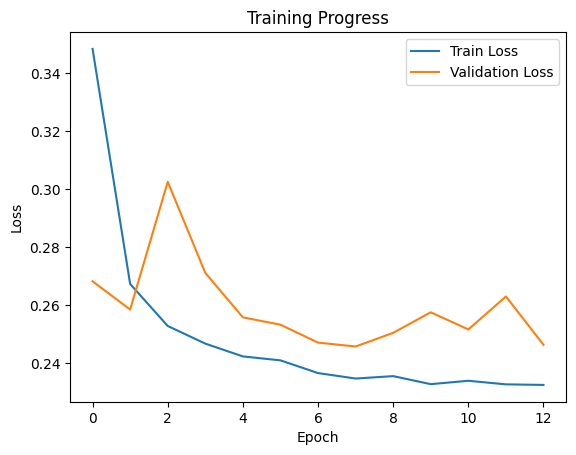

Etichetta vera: 1
Passo 1/90:
Feature: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0.]
Probabilità: 0.4169
----------------------------------------
Passo 2/90:
Feature: [0.    0.    0.143 0.    0.    1.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    1.   ]
Probabilità: 0.5592
----------------------------------------
Passo 3/90:
Feature: [0.    0.    0.143 0.143 0.    1.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    1.   ]
Probabilità: 0.7260
----------------------------------------
Passo 4/90:
Feature: [0.    0.    0.143 0.286 0.    1.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
 0.    0.   ]
Probabilità: 0.8435
----------------------------------------
Passo 5/90:
Feature: [0.    0.    0.143 0.429 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    1

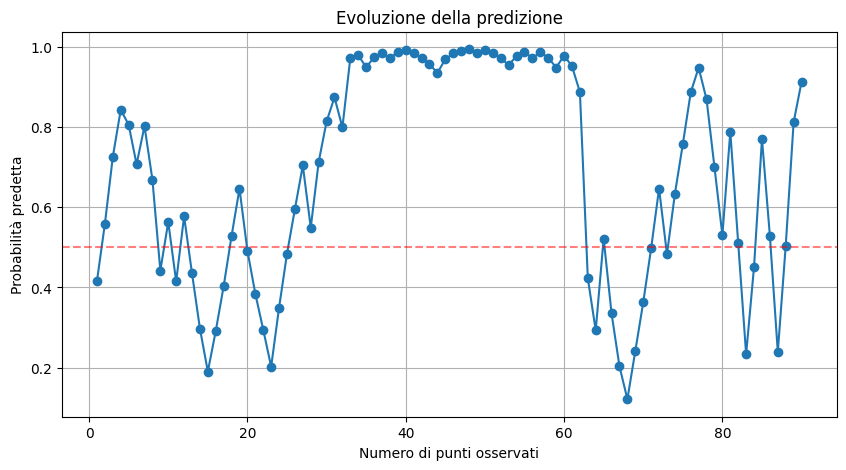

In [ ]:
# ---------- 1. MODELLO AGGIORNATO ----------
class LSTMPerStep(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_size, 1)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x, lengths, hidden=None):
        lengths = lengths.cpu()
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.lstm(packed, hidden)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = self.dropout(output)
        logits = self.output_layer(output)  # (batch, seq_len, 1)
        probs = torch.sigmoid(logits).squeeze(-1)  # (batch, seq_len)
        return probs, hidden

    def init_hidden(self, batch_size, device):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

# ---------- 2. NUOVA LOSS PESATA ----------
def exponential_weighted_loss(y_pred, y_true, lengths, device, final_weight=10.0):
    """
    Loss che aumenta esponenzialmente il peso verso la fine della sequenza
    """
    batch_size, max_len = y_pred.shape
    weights = torch.ones_like(y_pred, device=device)

    # Crea pesi esponenziali per ogni sequenza nel batch
    for i in range(batch_size):
        L = lengths[i].item()
        # Peso base cresce esponenzialmente verso la fine
        t = torch.arange(0, L, device=device).float()
        sequence_weights = torch.exp(final_weight * (t / L - 1))

        # Normalizza per mantenere l'impatto complessivo simile
        sequence_weights = sequence_weights / sequence_weights.mean()
        weights[i, :L] = sequence_weights

    # Calcola BCE pesata
    loss = F.binary_cross_entropy(y_pred, y_true, reduction='none')
    weighted_loss = loss * weights

    # Calcola solo sulle posizioni valide
    mask = torch.arange(max_len, device=device)[None, :] < lengths[:, None]
    valid_loss = weighted_loss[mask].mean()

    return valid_loss

# ---------- 3. TRAINING LOOP RIVISTO ----------
def train(model, train_loader, val_loader, optimizer, device, epochs=50, patience=5):
    best_val_loss = float('inf')
    counter = 0
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch, lengths in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            lengths = lengths.to(device)

            optimizer.zero_grad()

            # Forward pass
            preds, _ = model(X_batch, lengths)

            # Crea target espansi per ogni passo temporale
            y_expanded = y_batch.unsqueeze(1).repeat(1, preds.size(1))

            # Calcola loss
            loss = exponential_weighted_loss(preds, y_expanded, lengths, device)

            # Backpropagazione
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()

        # Validation
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch, lengths in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                lengths = lengths.to(device)

                preds, _ = model(X_batch, lengths)
                y_expanded = y_batch.unsqueeze(1).repeat(1, preds.size(1))
                loss = exponential_weighted_loss(preds, y_expanded, lengths, device)
                val_loss += loss.item()

        # Calcola medie
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Carica il miglior modello
    model.load_state_dict(torch.load('best_model.pth'))
    return history

# ---------- 4. PREDIZIONE EFFICIENTE CON STATO PERSISTENTE ----------
def predict_sequence_steps(model, X_seq, device):
    model.eval()
    X_seq = X_seq.unsqueeze(0).to(device)  # [1, seq_len, input_dim]
    seq_len = X_seq.size(1)
    probs = []

    # Inizializza lo stato nascosto
    hidden = model.init_hidden(1, device)

    with torch.no_grad():
        # Elabora la sequenza incrementale
        for t in range(1, seq_len + 1):
            input_step = X_seq[:, :t, :]
            lengths = torch.tensor([t], dtype=torch.long).to(device)

            # Passa attraverso il modello mantenendo lo stato
            output, hidden = model(input_step, lengths, hidden)
            prob = output[0, -1].item()
            probs.append(prob)

            # Stampa diagnostica
            print(f"Passo {t}/{seq_len}:")
            print(f"Feature: {input_step[0, -1, :].cpu().numpy().round(3)}")
            print(f"Probabilità: {prob:.4f}")
            print("-" * 40)

    return probs

# ---------- 5. ESEMPIO DI UTILIZZO AGGIORNATO ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 26
hidden_size = 64

model = LSTMPerStep(input_size=input_size, hidden_size=hidden_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Preparazione dati (assumendo che 'dataset' sia già definito)
match_ids = dataset['match_id'].unique()
train_ids, test_ids = train_test_split(match_ids, test_size=0.2, random_state=42)
train_data = dataset[dataset['match_id'].isin(train_ids)]
test_data = dataset[dataset['match_id'].isin(test_ids)]

train_data = augment_with_symmetric(train_data)
test_data = augment_with_symmetric(test_data)

# Creazione DataLoader (implementa la tua funzione prepare_datasets)
train_loader, val_loader, test_loader, feature_cols = prepare_datasets(
    train_data, test_data, target_col='SetWinner', batch_size=32, val_split=0.1
)

# Allenamento
history = train(model, train_loader, val_loader, optimizer, device, epochs=100)

# Plot della loss
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plt.show()

# Predizione su una sequenza di test
X_test, y_test, lengths = next(iter(test_loader))
X_seq = X_test[0][:lengths[0]]  # Sequenza completa

print(f"Etichetta vera: {int(y_test[0].item())}")
full_probs = predict_sequence_steps(model, X_seq, device)

# Plot evoluzione probabilità
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(full_probs) + 1), full_probs, marker='o')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
plt.xlabel("Numero di punti osservati")
plt.ylabel("Probabilità predetta")
plt.title("Evoluzione della predizione")
plt.grid(True)
plt.show()

# **TT**

In [ ]:
# Importiamo il dataset ottenuto tramite le operazioni di Data Preprocessing
dataset = pd.read_csv("TT.csv")
dataset

,player_id,opponent_id,Set1,Set2,points_progression,SetWinner,MatchWinner,event_match_id,PointWinner,PtSet,Pt,Pts,WonSetP1,WonSetP2,LostSetP1,LostSetP2
0,112463,117294,0,0,2,2,1,1,2,1,1,0-0,0,0,0,0
1,112463,117294,0,0,2,2,1,1,2,2,2,0-1,0,0,0,0
2,112463,117294,0,0,1,2,1,1,1,3,3,0-2,0,0,0,0
3,112463,117294,0,0,1,2,1,1,1,4,4,1-2,0,0,0,0
4,112463,117294,0,0,2,2,1,1,2,5,5,2-2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222644,133652,133850,2,1,1,1,1,19561,1,14,66,8-5,0,0,0,0
1222645,133652,133850,2,1,2,1,1,19561,2,15,67,9-5,0,0,0,0
1222646,133652,133850,2,1,2,1,1,19561,2,16,68,9-6,0,0,0,0
1222647,133652,133850,2,1,1,1,1,19561,1,17,69,9-7,0,0,0,0


In [ ]:
# Split 'Pts'
dataset[['Pt1_raw', 'Pt2_raw']] = dataset['Pts'].astype(str).str.split('-', expand=True)

score_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'AD':11}

dataset['Pt1'] = dataset['Pt1_raw'].map(score_map)
dataset['Pt2'] = dataset['Pt2_raw'].map(score_map)
dataset['SetID'] = dataset['event_match_id'].astype(str) + dataset['Set1'].astype(str) + dataset['Set2'].astype(str)


# Definisci IsDeuce per game normale
normal_deuce = (
    (
        ((dataset['Pt1'] == 10) & (dataset['Pt2'] == 10)) |   # 40-40
        ((dataset['Pt1'] == 11) & (dataset['Pt2'] == 10)) |   # 40-ADV
        ((dataset['Pt1'] == 10) & (dataset['Pt2'] == 11))     # ADV-40
    )
)


# Combina i due casi
dataset['IsDeuce'] = (normal_deuce).astype(int)

dataset.drop(columns=['Pt1_raw', 'Pt2_raw','Pts','points_progression'], inplace=True)

In [ ]:
dataset

In [ ]:
# Generazione delle partite inverse per aumentare la dimensione del dataset

def augment_with_symmetric(df: pd.DataFrame) -> pd.DataFrame:
    df_swapped = df.copy()

    # Colonne da swappare a coppie
    swap_pairs = [
        ('Set1', 'Set2'),
        ('Pt1', 'Pt2'),
        ('player_id', 'opponent_id'),
        ('WonSetP1', 'WonSetP2'),
        ('LostSetP1', 'LostSetP2'),
        ('player_id',	'opponent_id')
    ]

    for col1, col2 in swap_pairs:
        df_swapped[[col1, col2]] = df[[col2, col1]].values

    # Colonne dove 1 <-> 2
    invert_1_2_cols = ['PointWinner', 'SetWinner', 'MatchWinner']
    for col in invert_1_2_cols:
        df_swapped[col] = df[col].replace({1: 2, 2: 1})


    # Aggiunta del suffisso 'simm' a match_id e set_id, se presenti
    for col in ['event_match_id', 'SetID']:
        if col in df_swapped.columns:
            df_swapped[col] = df_swapped[col].astype(str) + '_simm'

    return pd.concat([df, df_swapped], ignore_index=True)